<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/LG_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google driver에 있는 데이터 공유를 위한 설치 패키지
!pip install gdrive_dataset

In [ ]:
# 예를 들어: https://drive.google.com/file/d/abcdefgABCDEFG1234567/view 이 있다면
# abcdefgABCDEFG1234567 이 위치가 file_id 입니다.

In [2]:
from gdrivedataset import loader

# file_id = # 이곳에 file_id 를 입력
file_id ='1DOYRWtzDlynJ0VJqDtdluzHXBzkJLZgE'
loader.load_from_google_drive(file_id)

========== files ============

data/test.zip
data/train.zip
data/train.csv
data/sample_submission.csv



In [ ]:
!unzip data/train.zip -d data

In [ ]:
!unzip data/test.zip - data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [19]:
train_data_list = glob('data/train/*')

 -- train_data -- 
data/train/63832


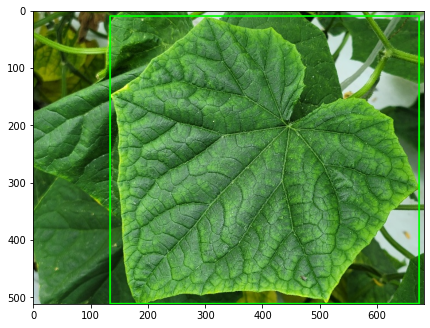

 -- train_data -- 
data/train/53736


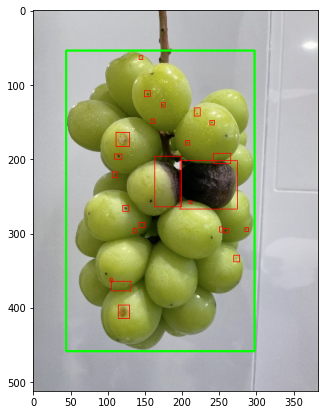

 -- train_data -- 
data/train/22960


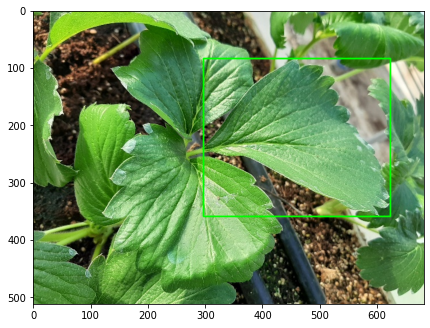

 -- train_data -- 
data/train/46723


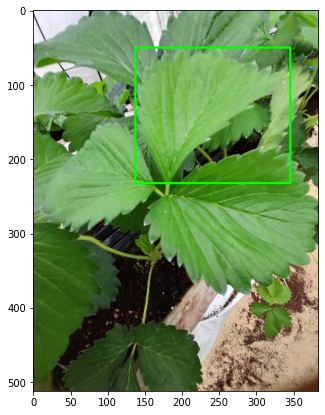

In [23]:
for train_data in train_data_list[:4]:
  print(" -- train_data -- ")
  print(train_data)

  sample_csv = pd.read_csv(glob(train_data+'/*.csv')[0])
  sample_image = cv2.imread(glob(train_data+'/*.jpg')[0])
  sample_json = json.load(open(glob(train_data+'/*.json')[0], 'r'))

  # visualize bbox
  plt.figure(figsize=(7,7))
  points = sample_json['annotations']['bbox'][0]
  part_points = sample_json['annotations']['part']
  img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

  cv2.rectangle(
      img,
      (int(points['x']), int(points['y'])),
      (int((points['x']+points['w'])), int((points['y']+points['h']))),
      (0, 255, 0),
      2
  )
  for part_point in part_points:
      point = part_point
      cv2.rectangle(
          img,
          (int(point['x']), int(point['y'])),
          (int((point['x']+point['w'])), int((point['y']+point['h']))),
          (255, 0, 0),
          1
      )
  plt.imshow(img)
  plt.show()